# Time Series Clustering using TSFresh + KMeans

In this notebook, we will train a KMeans Clustering algorithm with default settings from [sklearn.cluster](https://scikit-learn.org/stable/modules/clustering.html) module of Python package [scikit-learn](https://github.com/scikit-learn/scikit-learn)

To transform Time Series data into usual tablar data we are using [TSFresh](https://tsfresh.readthedocs.io/en/latest/) python package. It automatically calculates a large number of time series characteristics, the so called features. 

The data used in this analysis is publicly available via UCI Archive under Online Retail II Data Set.

We have cleaned and preprocessed this dataset in the optional notebook: 01. Optional - Data Cleaning and Preparation. The reader may directly use the preprocessed data included in the repository under: ./data/df_pivoted.zip for running this notebook.

Tested with Python3, Pandas version 1.3.4.

*References*
* Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
* Direct link to UCI dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx
* scikit-learn github repo: https://github.com/scikit-learn/scikit-learn
* tsfresh github repo: https://github.com/blue-yonder/tsfresh

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# optional - suppress warnings

import warnings
warnings.filterwarnings("ignore")

### Load data

In [3]:
df_pivoted = pd.read_csv('./data/df_pivoted.zip', low_memory=False)
print(df_pivoted.shape, df_pivoted.columns)
df_pivoted.head()

(4605, 375) Index(['StockCode', '2009-12-01 00:00:00', '2009-12-02 00:00:00',
       '2009-12-03 00:00:00', '2009-12-04 00:00:00', '2009-12-05 00:00:00',
       '2009-12-06 00:00:00', '2009-12-07 00:00:00', '2009-12-08 00:00:00',
       '2009-12-09 00:00:00',
       ...
       '2010-11-30 00:00:00', '2010-12-01 00:00:00', '2010-12-02 00:00:00',
       '2010-12-03 00:00:00', '2010-12-04 00:00:00', '2010-12-05 00:00:00',
       '2010-12-06 00:00:00', '2010-12-07 00:00:00', '2010-12-08 00:00:00',
       '2010-12-09 00:00:00'],
      dtype='object', length=375)


,StockCode,2009-12-01 00:00:00,2009-12-02 00:00:00,2009-12-03 00:00:00,2009-12-04 00:00:00,2009-12-05 00:00:00,2009-12-06 00:00:00,2009-12-07 00:00:00,2009-12-08 00:00:00,2009-12-09 00:00:00,...,2010-11-30 00:00:00,2010-12-01 00:00:00,2010-12-02 00:00:00,2010-12-03 00:00:00,2010-12-04 00:00:00,2010-12-05 00:00:00,2010-12-06 00:00:00,2010-12-07 00:00:00,2010-12-08 00:00:00,2010-12-09 00:00:00
0,10002,12.0,0.0,7.0,73.0,0.0,49.0,2.0,12.0,0.0,...,12.0,60.0,1.0,8.0,0.0,1.0,25.0,8.0,13.0,44.0
1,10080,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10109,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10120,60.0,10.0,0.0,30.0,0.0,0.0,0.0,1.0,1.0,...,10.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,12.0,0.0
4,10125,5.0,0.0,0.0,46.0,0.0,8.0,20.0,1.0,22.0,...,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,40.0,0.0


In [4]:
# transpose data to match format neeed for further processing
df_final = df_pivoted.melt(id_vars=['StockCode'], var_name='timestamp', value_name='target_value')
print(df_final.shape, df_final.columns)

df_final.head()

(1722270, 3) Index(['StockCode', 'timestamp', 'target_value'], dtype='object')


,StockCode,timestamp,target_value
0,10002,2009-12-01 00:00:00,12.0
1,10080,2009-12-01 00:00:00,0.0
2,10109,2009-12-01 00:00:00,0.0
3,10120,2009-12-01 00:00:00,60.0
4,10125,2009-12-01 00:00:00,5.0


## Extracting features with TSFresh

In [5]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Generate metrics/features with TSFresh Library. 
The purpose of doing this is to convert sequential data to a flattened format so an euclidean distance metric can be used for clustering. Else, a distance metric like Dynamic Time Warp will have to be utilised instead. Refer to [here](http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html) for more info.

In [6]:
from tsfresh import extract_features
extracted_features = extract_features(df_final, column_id="StockCode", column_sort="timestamp")

Feature Extraction: 100%|██████████| 40/40 [01:14<00:00,  1.86s/it]


In [7]:
print(extracted_features.shape, extracted_features.columns)
extracted_features

(4605, 789) Index(['target_value__variance_larger_than_standard_deviation',
       'target_value__has_duplicate_max', 'target_value__has_duplicate_min',
       'target_value__has_duplicate', 'target_value__sum_values',
       'target_value__abs_energy', 'target_value__mean_abs_change',
       'target_value__mean_change',
       'target_value__mean_second_derivative_central', 'target_value__median',
       ...
       'target_value__permutation_entropy__dimension_6__tau_1',
       'target_value__permutation_entropy__dimension_7__tau_1',
       'target_value__query_similarity_count__query_None__threshold_0.0',
       'target_value__matrix_profile__feature_"min"__threshold_0.98',
       'target_value__matrix_profile__feature_"max"__threshold_0.98',
       'target_value__matrix_profile__feature_"mean"__threshold_0.98',
       'target_value__matrix_profile__feature_"median"__threshold_0.98',
       'target_value__matrix_profile__feature_"25"__threshold_0.98',
       'target_value__matrix_pro

,target_value__variance_larger_than_standard_deviation,target_value__has_duplicate_max,target_value__has_duplicate_min,target_value__has_duplicate,target_value__sum_values,target_value__abs_energy,target_value__mean_abs_change,target_value__mean_change,target_value__mean_second_derivative_central,target_value__median,...,target_value__permutation_entropy__dimension_6__tau_1,target_value__permutation_entropy__dimension_7__tau_1,target_value__query_similarity_count__query_None__threshold_0.0,"target_value__matrix_profile__feature_""min""__threshold_0.98","target_value__matrix_profile__feature_""max""__threshold_0.98","target_value__matrix_profile__feature_""mean""__threshold_0.98","target_value__matrix_profile__feature_""median""__threshold_0.98","target_value__matrix_profile__feature_""25""__threshold_0.98","target_value__matrix_profile__feature_""75""__threshold_0.98",target_value__mean_n_absolute_max__number_of_maxima_7
10002,1.0,0.0,0.0,1.0,6753.0,1246425.0,29.731903,0.085791,0.057796,0.0,...,4.662470,5.267111,NaN,1.156394,6.322159,3.359248,3.319631,2.769635,4.002091,338.571429
10002R,0.0,0.0,1.0,1.0,4.0,6.0,0.021448,0.000000,-0.001344,0.0,...,0.195072,0.229094,NaN,3.403340,10.392305,9.608496,10.392305,10.392305,10.392305,0.571429
10080,1.0,0.0,1.0,1.0,102.0,8148.0,0.546917,0.000000,-0.001344,0.0,...,0.358621,0.418636,NaN,3.296090,20.249251,16.705905,19.570023,18.547708,20.140483,14.571429
10109,0.0,0.0,0.0,1.0,0.0,32.0,0.042895,0.000000,0.000000,0.0,...,0.149591,0.168646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142857
10120,1.0,0.0,0.0,1.0,-8543.0,81014083.0,50.504021,-0.160858,0.051075,0.0,...,1.763682,2.045770,NaN,7.667704,13.634972,10.415854,10.383684,9.674647,10.782501,1316.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DCGS0076,0.0,1.0,1.0,1.0,15.0,21.0,0.077748,0.002681,0.001344,0.0,...,0.657521,0.775974,NaN,4.749877,10.909360,6.401396,6.258926,4.749877,7.215392,1.428571
DCGSLBOY,0.0,1.0,0.0,1.0,-16.0,256.0,0.085791,0.000000,0.000000,0.0,...,0.093550,0.112498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.285714
DCGSLGIRL,1.0,1.0,0.0,1.0,-57.0,3249.0,0.305630,0.000000,0.000000,0.0,...,0.093550,0.112498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.142857
DCGSSBOY,1.0,0.0,0.0,1.0,40.0,18236.0,1.152815,0.000000,0.000000,0.0,...,0.684382,0.793123,NaN,2.119894,14.696938,10.293823,13.314396,6.115070,14.556950,30.571429


### Drop all columns with na values

In [8]:
extracted_features_cleaned=extracted_features
extracted_features_cleaned=extracted_features_cleaned.dropna(axis=1)
extracted_features_cleaned

,target_value__variance_larger_than_standard_deviation,target_value__has_duplicate_max,target_value__has_duplicate_min,target_value__has_duplicate,target_value__sum_values,target_value__abs_energy,target_value__mean_abs_change,target_value__mean_change,target_value__mean_second_derivative_central,target_value__median,...,target_value__lempel_ziv_complexity__bins_3,target_value__lempel_ziv_complexity__bins_5,target_value__lempel_ziv_complexity__bins_10,target_value__lempel_ziv_complexity__bins_100,target_value__permutation_entropy__dimension_3__tau_1,target_value__permutation_entropy__dimension_4__tau_1,target_value__permutation_entropy__dimension_5__tau_1,target_value__permutation_entropy__dimension_6__tau_1,target_value__permutation_entropy__dimension_7__tau_1,target_value__mean_n_absolute_max__number_of_maxima_7
10002,1.0,0.0,0.0,1.0,6753.0,1246425.0,29.731903,0.085791,0.057796,0.0,...,0.141711,0.117647,0.229947,0.323529,1.587381,2.682183,3.783314,4.662470,5.267111,338.571429
10002R,0.0,0.0,1.0,1.0,4.0,6.0,0.021448,0.000000,-0.001344,0.0,...,0.077540,0.077540,0.077540,0.077540,0.093745,0.127398,0.161174,0.195072,0.229094,0.571429
10080,1.0,0.0,1.0,1.0,102.0,8148.0,0.546917,0.000000,-0.001344,0.0,...,0.072193,0.072193,0.072193,0.080214,0.172133,0.239002,0.298743,0.358621,0.418636,14.571429
10109,0.0,0.0,0.0,1.0,0.0,32.0,0.042895,0.000000,0.000000,0.0,...,0.074866,0.074866,0.074866,0.074866,0.074339,0.111721,0.130616,0.149591,0.168646,1.142857
10120,1.0,0.0,0.0,1.0,-8543.0,81014083.0,50.504021,-0.160858,0.051075,0.0,...,0.072193,0.072193,0.072193,0.072193,0.704224,1.089593,1.449027,1.763682,2.045770,1316.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DCGS0076,0.0,1.0,1.0,1.0,15.0,21.0,0.077748,0.002681,0.001344,0.0,...,0.093583,0.093583,0.093583,0.093583,0.265587,0.397489,0.528355,0.657521,0.775974,1.428571
DCGSLBOY,0.0,1.0,0.0,1.0,-16.0,256.0,0.085791,0.000000,0.000000,0.0,...,0.072193,0.072193,0.072193,0.072193,0.037184,0.055893,0.074682,0.093550,0.112498,2.285714
DCGSLGIRL,1.0,1.0,0.0,1.0,-57.0,3249.0,0.305630,0.000000,0.000000,0.0,...,0.072193,0.072193,0.072193,0.072193,0.037184,0.055893,0.074682,0.093550,0.112498,8.142857
DCGSSBOY,1.0,0.0,0.0,1.0,40.0,18236.0,1.152815,0.000000,0.000000,0.0,...,0.074866,0.074866,0.077540,0.088235,0.268907,0.421381,0.556926,0.684382,0.793123,30.571429


### PCA (Dimension Reduction) + K-Means (Clustering)

In [9]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Values in extracted features consist of both negative and positive values. Hence standard scaler is used as opposed to minmax scaler

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
extracted_features_cleaned_std = scaler.fit_transform(extracted_features_cleaned)

Use PCA to do dimensionality reduction

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(extracted_features_cleaned_std)

PCA()

The explained variance ratio is the percentage of variance that is attributed by each of the selected components. You will typically determine the number of components to include in your model by adding the explained variance ratio of each component in a cumulative manner until you reach 0.8 to 0.9 to avoid overfitting. The optimal value usually happens at the elbow.

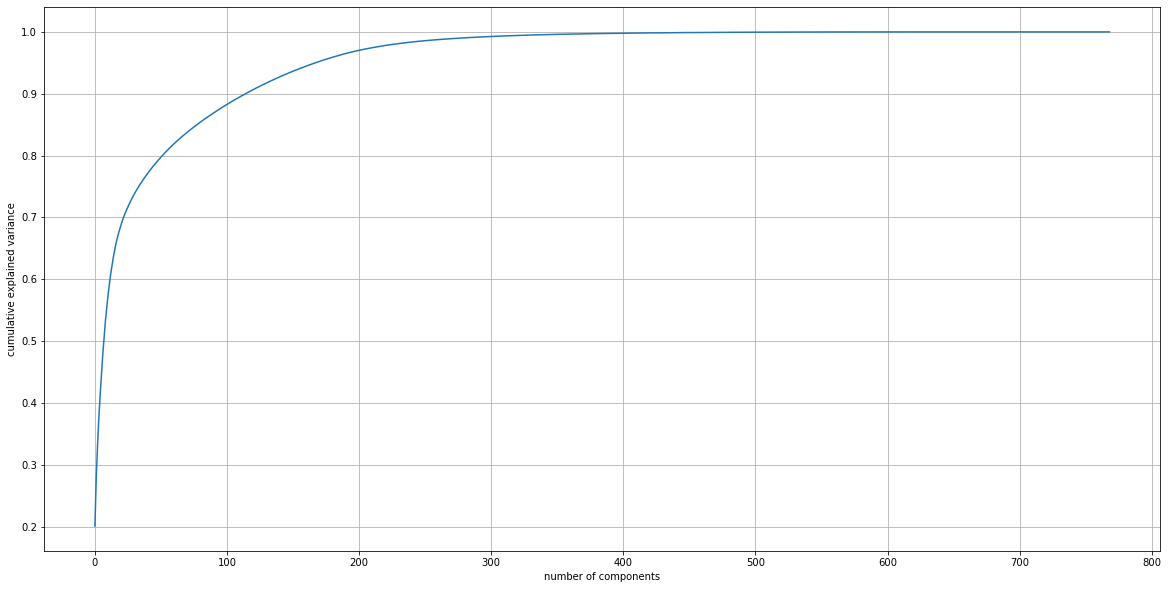

In [12]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

As can be seen from the chart above, the elbow value is approximately 100

In [13]:
pca = PCA(n_components=100)
pca.fit(extracted_features_cleaned_std)

PCA(n_components=100)

In [14]:
scores_pca = pca.transform(extracted_features_cleaned_std)

Finding the optimal number of clusters to use - Adding more clusters decreases the inertia value but the information contained in each cluster also decreases. Hence we want to have a small cluster size with a relatively small inertia value. As with finding the optimal number of clusters, the elbow heuristic works well here.

In [15]:
from sklearn.cluster import KMeans

In [16]:
wcss = []
for i in range(1,10):
    km = KMeans(n_clusters=i) 
    km.fit(scores_pca)
    wcss.append(km.inertia_)

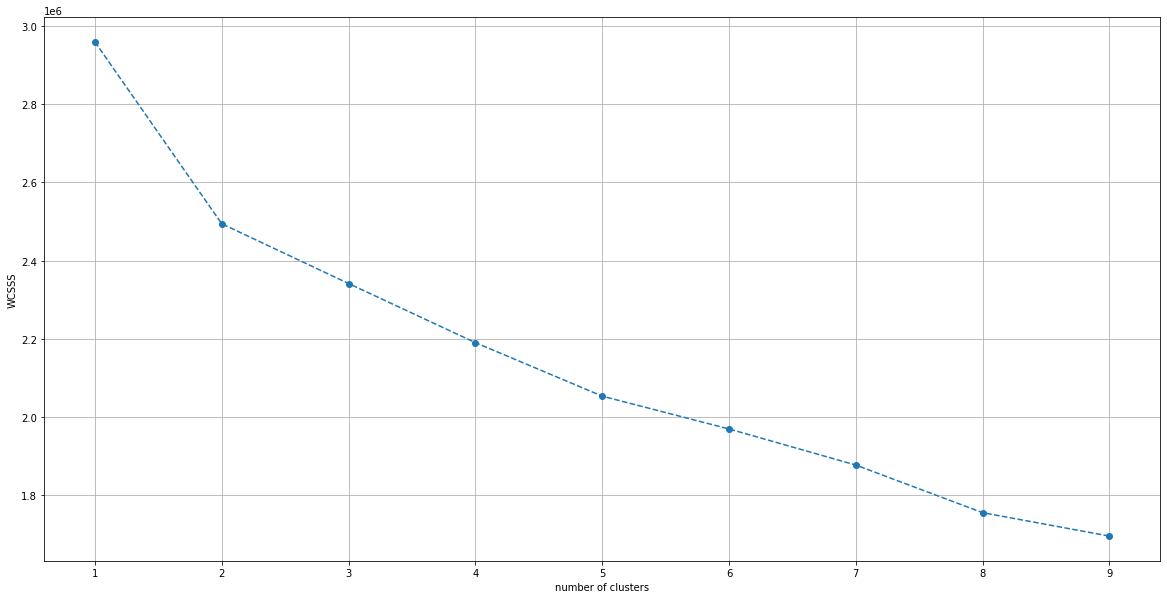

In [17]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.xlabel('number of clusters')
plt.ylabel('WCSSS');

As can be seen from the chart above, the elbow value is 2

In [18]:
# cluster configuration
N_CLUSTERS = 2

km = KMeans(
    n_clusters=N_CLUSTERS
)
pca_km = km.fit_predict(scores_pca)
np.unique(pca_km,return_counts=True)

(array([0, 1], dtype=int32), array([4558,   47]))

## Generate TTS for different clusters

### Train - Hold-out Split

Hold-out set offers a way for verifying model performance on unseen data. With this dataset, we are looking to forecast a week out (Forecast Horizon = 1 Week) and therefore leave out a week worth of data out from the TTS as holdout set.

In [19]:
# keep only the date part

df_final['timestamp'] = df_final['timestamp'].str[:10] 
df_final.head()

,StockCode,timestamp,target_value
0,10002,2009-12-01,12.0
1,10080,2009-12-01,0.0
2,10109,2009-12-01,0.0
3,10120,2009-12-01,60.0
4,10125,2009-12-01,5.0


In [20]:
min(df_final['timestamp']), max(df_final['timestamp'])

('2009-12-01', '2010-12-09')

In [21]:
df_train = df_final[df_final['timestamp'] < '2010-12-03']
df_test = df_final[df_final['timestamp'] > '2010-12-02']

df_final.shape, df_train.shape, df_test.shape

((1722270, 3), (1690035, 3), (32235, 3))

In [22]:
# verify that we have adequate coverage across train and test
df_final.StockCode.nunique(), df_train.StockCode.nunique(), df_test.StockCode.nunique()

(4605, 4605, 4605)

## Split data into clusters

In [23]:
# lookup dataframe with item_ids and corresponding labels
df_lbl = pd.DataFrame()
extracted_features_cleaned['StockCode']=extracted_features_cleaned.index
df_lbl['StockCode'] = extracted_features_cleaned['StockCode']
df_lbl['label'] = pca_km

df_lbl.shape, df_lbl.dtypes

((4605, 2),
 StockCode    object
 label         int32
 dtype: object)

In [24]:
# merge labels back to the TTS
df_mrg = df_train.merge(df_lbl, how='left')
df_mrg_test = df_test.merge(df_lbl, how='left')

print(df_mrg.shape, df_train.shape)
print(df_mrg_test.shape, df_test.shape)

(1690035, 4) (1690035, 3)
(32235, 4) (32235, 3)


In [25]:
df_mrg.sample(5)

,StockCode,timestamp,target_value,label
1272712,22556,2010-09-03,28.0,0
1675044,72331R,2010-11-29,0.0,0
575249,85186A,2010-04-04,0.0,0
1274317,47559B,2010-09-03,0.0,0
1230294,21444,2010-08-25,0.0,0


In [26]:
# create required directory structure
dir_paths = ['./train']
for i in range(N_CLUSTERS):
    dir_paths.append(f"./train/cls_{i+1}_TSF")

for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [27]:
# split and save TTS
record_count = 0
for i in range(N_CLUSTERS):
    df_tmp = df_mrg[['StockCode', 'timestamp', 'target_value']][df_mrg['label']==i]
    df_tmp.to_csv(f"./train/cls_{i+1}_TSF/tts_{i+1}_TSF.csv", header=None, index=None)
    df_tmp2 = df_mrg_test[['StockCode', 'timestamp', 'target_value']][df_mrg_test['label']==i]
    df_tmp2.to_csv(f"./train/cls_{i+1}_TSF/test_{i+1}_TSF.csv", header=None, index=None)
    record_count += df_tmp.shape[0]
    
print(record_count, df_mrg.shape[0])  # verify that all time series are retained

1690035 1690035


Now you can train separate predictors for each cluster